# Local Classifier Two-Sample Tests ($\ell$-C2ST)

After a density estimator has been trained with simulated data to obtain a posterior, the estimator should be made subject to several diagnostic tests, before being used for inference given the actual observed data. _Posterior Predictive Checks_ (see [previous tutorial](https://sbi-dev.github.io/sbi/tutorial/12_diagnostics_posterior_predictive_check/)) provide one way to "critique" a trained estimator via its predictive performance. Another approach is simulation-based calibration (see [previous tutorial](https://sbi-dev.github.io/sbi/tutorial/13_diagnostics_simulation_based_calibration/)), that evaluates whether the estimated posterior is balanced, i.e., neither over-confident nor under-confident. These checks are peformed ***in expectation (on average) over the observation space***. As such, SBC is a ***global validation method*** that can be viewed as a necessary condition (but not sufficient) for a valid inference algorithm: If SBC checks fail, this tells you that your inference is invalid. If SBC checks pass, *this is no guarantee that the posterior estimation is working*.

**Local Classifier Two-Sample Tests** ($\ell$-C2ST) as developed by [Linhart et al, 2023](https://arxiv.org/abs/2306.03580) present a new ***local validation method*** that allow to evaluate the correctness of the posterior estimator ***at a fixed observation***. They provide necessary *and sufficient* conditions for the validity of the SBI-algorithm, as well as easy-to-interpret qualitative and quantiative diagnostics: If global checks (like SBC) fail, this enables to further investigate where (for which observation) and why (bias, overdispersion, etc.) the posterior estimator fails. If global validation checks pass, this allows to guarantee whether the inference is correct for a specific observation. 



## In a nutshell

Suppose you have an "amortized" posterior estimator $q_\phi(\theta\mid x)$, meaning that we can quickly get samples for any new observation $x$.

To run $\ell$-C2ST, 

1. we sample **new** parameters from the prior of the problem at hand: $\Theta_i \sim p(\theta)$
2. we simulate corresponding "observations": $X_i = \mathrm{Simulator}(\Theta_i) \sim p(x\mid \Theta_i)$
3. we sample the estimated posterior at each observation: $Q_i \sim q_\phi(\theta \mid X_i)$

This creates a calibration dataset of samples from the "estimated" and true joint distributions on which we train a binary classifier $d(\theta, x)$ to distinguish between the estimated joint $q(\theta \mid x)p(x)$ (class $C=0$) and the true joint distribution $p(\theta)p(x\mid\theta)$ (class $C=1$):

$$\mathcal{D}_\mathrm{cal} = \left \{\underbrace{(Q_i, X_i)}_{(C=0)} \cup \underbrace{(\Theta_i, X_i)}_{(C=1)} \right \}_{i=1}^{N_\mathrm{cal}}$$

> Note: $D_\mathrm{cal}$ contains data from the joint distribution (over prior and simulator) that have to be **different from the data used to train the posterior estimator**. $N_\mathrm{cal}$ is typically smaller than $N_\mathrm{train}$, the number of training samples for the posterior estimator, but has to be sufficiently large to allow the convergence of the classifier. For a fixed simulation budget, a rule of thumb is to use $90\%$ for the posterior estimation and $10\%$ for the calibration.

Once the classifier is trained, we evaluate it for a given observation $x^\star$ and multiple samples $Q^\star_i \sim q_\phi(\theta \mid x^\star)$. This gives us a set of predicted probabilities $\left\{d(Q^\star_i, x^\star)\right\}_{i=1}^{N_\mathrm{eval}}$ that are then used to compute the different diagnostics. This proceedure can be repeated for several different observations, without having to retrain the classifiers, which allows to perform an efficient and thorough analysis of the failure modes of the posterior estimator.

> Note: The number of evaluation samples can be arbitrarily large (typically we use $N_\mathrm{eval} = 10\,000$), because we suppose our posterior estimator to be amortized. 

### Key ideas behind $\ell$-C2ST

$\ell$-C2ST allows to evaluate the correctness your posterior estimator *without requiring access to samples from the true posterior*. It is built on the following two key ideas:

1. **Train the classifier on the joint:** this allows to implicitly learn the distance between the true and estimated posterior for any observation (we could call this step "amortized" C2ST training). 

2. **Local evaluation on data from one class only:** we use a metric that, as opposed to the accuracy (used in C2ST) does not require samples from the true posterior, only the estimator. It consists in the Mean Squared Error (MSE) between the predicted probabilities for samples from the estimator evaluated at the given observation and one half.

> Note: A predicted probability of one half corresponds to the chance level or total uncertainty of the classifier, that is unable to distinguish between the two data classes.

The MSE metric is used as a test statistic inside a hypothesis test that gives us theoretical guarantees on the correctness of the posterior estimator (at the considered observation), as well as esay-to-interpret diagnostics that allow to investigate its failure modes.

>**Quick reminder on hypothesis tests.** Additionaly to the observed test statistic $T^\star$, evaluating the test requires to
>1. compute the test statistics $T_h$ under the null hyposthesis (H0) of equal (true and estimated) distributions over multiple trials $h$.
>2. compute the p-value $p_v = \frac{1}{H}\sum_{h=1}^H \mathbb{I}(T_h > T^\star)$: *"How many times is the observed test statistic "better" (i.e. below) the test statistic computed under H0?"*
>3. choose a significance level $\alpha$ (typically $0.05$) that defines the rejection threshold and evaluate the test:
>- **quantitatively:** a p-value below this level indicates the rejection of the null hypothesis, meaning the detection of significant differences between the true and the estimated posterior. 
>- **qualitatively:** PP-plots: visually check whether the distribution of $T^\star$ falls into the $1-\alpha$ confidence region, computed by taking the corresponding quantiles of $(T_1,\dots, T_H)$.

### What can $\ell$-C2ST diagnose?

- **Quantitatively:** the MSE metric (or test statistic) gives us a distance measure between the estimated and true posterior that can be quickly evaluated for any new observation $x^\star$. Comparing it to the values of the null-distribution gives us the p-values that are used to check how significant their differences are. If the check passes (no significant differences), this tells us that we can be confident about the correctness of the estimator, but only upto to a certain confidence level (typically $95\%$). 

- **Qualitatively:** we can choose to look at the predicted probabilities used to compute the MSE metric. PP-plots allow to evaluate a general trend of over or under confidence, by comparing theire distribution to the confidence region (obtained for probabilities predicted under H0). We can go further and map these predicted probabilities to a pairplot of the samples they were evaluated on, shows us the regions of over and underconfidence of the estimator. This allows us to investigate the nature of the inconsistencies, such as positive/negative bias or under/over dispersion.

> Note: High (resp. low) predicted probability indicates that the classifier is confident about the fact that the sample belongs to the estimated posterior (resp. to the true posterior). This means that the estimator associates too much (resp. not enough) mass to this sample. In other words it is "over-confident" (resp. "under-confident"). 



To summarize $\ell$-C2ST can:

- tell you whether your posterior estimator is valid for a given observation (with a guaranteed confidence)
- show you where (for which observation) and why (bais, overdispersion, etc.) it fails 

## Illustration on a benchmark SBI example

We consider the Gaussian Mixture SBI task from [Lueckmann et al, 2021](https://arxiv.org/abs/2101.04653). It consists of inferring the common mean of a mixture of two two-dimensional Gaussian distributions, one with much broader covariance than the other:
- Prior: $p(\theta) = \mathcal{U}(-10,10)$
- Simulator: $p(x|\theta) = 0.5 \mathcal{N}(\theta, \mathbf{I}_2)+ 0.5 \mathcal{N}(\theta, 0.1 \times \mathbf{I}_2)$
- Dimensionality: $\theta \in \mathbb{R}^2$, $x \in \mathbb{R}^2$

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

### SBI Task

In [16]:
from sbi.simulators.gaussian_mixture import GaussianMixture

# SBI task: prior and simualtor
gmm = GaussianMixture()
prior = gmm.prior_dist
simulator = gmm.get_simulator()

# Number of samples for training, calibration and evaluation
N_TRAIN = 10_000
N_CAL = int(0.1 * N_TRAIN) # 10% of the training data
N_EVAL = 10_000

### Posterior Inference

We use neural posterior estimation as our SBI-algorithm with a MAF as underlying density estimator. 

> Note: Here you could use any other SBI algorithm of your own choosing (e.g. NRE, NLE, etc.). IMPORTANT: make sure it is amortized (which corresponds to sequential methods with a signle round). 

We train the estimator on a small training set (`small_n_train=1000`) over a small number of epochs (`max_num_epochs=10`), which means that it doesn't converge. Therefore the diagnostics should detect major differences between the estimated and the true posterior (rejected null hypothesis).

> Note: You can play with the number of training samples or epochs to see whether this influences the quality of the posterior estimator and how it is reflected in the diagnostics.

In [17]:
from sbi.inference import SNPE, prepare_for_sbi

torch.manual_seed(42) # seed for reproducibility

# Prepare the simulator and prior for inference
simulator, prior = prepare_for_sbi(simulator, prior)

# Sample training data for the density estimator
small_n_train = 1000
theta_train = prior.sample((N_TRAIN,))[:small_n_train]
x_train = simulator(theta_train)[:small_n_train]

# Train the neural posterior estimators
torch.manual_seed(42) # seed for reproducibility
inference = SNPE(prior, density_estimator='maf', device='cpu')
inference = inference.append_simulations(theta=theta_train, x=x_train)
npe = inference.train(training_batch_size=256, max_num_epochs=10)

 Training neural network. Epochs trained: 11

### Evaluate the posterior estimator

We choose to evaluate the posterior estimator at three different observations, simulated from parameters independantly sampled from the prior: 
$$\theta^\star_i \sim p(\theta) \quad \rightarrow \quad x^\star_i \sim p(x\mid \theta_i), \quad i=1,2,3~.$$

In [18]:
# get reference observations
torch.manual_seed(0) # seed for reproducibility
thetas_star = prior.sample((3,))
xs_star = simulator(thetas_star)

# Sample from the true and estimated posterior
post_samples_star = {}
ref_samples_star = {}
for i,x in enumerate(xs_star):
    post_samples_star[i] = npe.sample((N_EVAL,), condition=x).detach()
    ref_samples_star[i] = gmm._sample_reference_posterior(
        num_samples=1000,
        observation=x[None,:]
    )

#### Set-up $\ell$-C2ST

>Note: we choose the default configuration with a MLP classifier (`classifier='mlp'`). You can also choose to use the default Random-Forest classifier (`classifier='rf'`) or use your own custom sklearn classifier by specifying `clf_class` and `clf_kwargs` during the intialization of the `LC2ST` class.

In [23]:
from sbi.diagnostics.lc2st import LC2ST

torch.manual_seed(42) # seed for reproducibility

# sample calibration data
theta_cal = prior.sample((N_CAL,))
x_cal = simulator(theta_cal)
post_samples_cal = npe.sample((1,), x_cal)[:,0,:].detach()

# set up the LC2ST: train the classifiers
lc2st = LC2ST(
    thetas=theta_cal,
    xs=x_cal,
    posterior_samples=post_samples_cal,
    classifier="mlp"
)
_ = lc2st.train_null() # over 100 trials under (H0)
_ = lc2st.train_data() # on observed data

Training the classifiers under (H0) - permutation = True: 100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


In [24]:
# Define significance level
conf_alpha = 0.05

#### Quantitative diagnostics
Test statistics, confidence regions and p-values

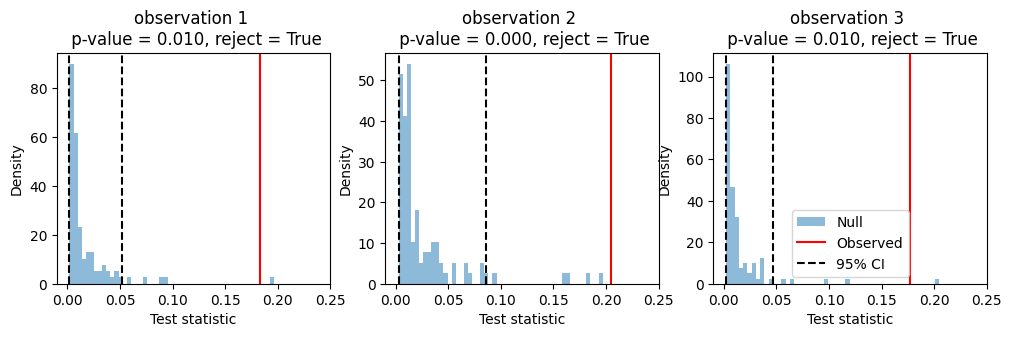

In [25]:
fig, axes = plt.subplots(1,len(thetas_star), figsize=(12,3))
for i in range(len(thetas_star)):
    probas, scores = lc2st.scores_data(
        P_eval=post_samples_star[i],
        x_eval=xs_star[i],
        return_probas=True
    )
    T_data = lc2st.statistic_data(P_eval=post_samples_star[i], x_eval=xs_star[i])
    T_null = lc2st.statistics_null(P_eval=post_samples_star[i], x_eval=xs_star[i])
    p_value = lc2st.p_value(post_samples_star[i], xs_star[i])
    reject = lc2st.reject(post_samples_star[i], xs_star[i], alpha=conf_alpha)

    # plot 95% confidence interval
    quantiles = np.quantile(T_null, [0, 1-conf_alpha])
    axes[i].hist(T_null, bins=50, density=True, alpha=0.5, label="Null")
    axes[i].axvline(T_data, color="red", label="Observed")
    axes[i].axvline(quantiles[0], color="black", linestyle="--", label="95% CI")
    axes[i].axvline(quantiles[1], color="black", linestyle="--")
    axes[i].set_xlabel("Test statistic")
    axes[i].set_ylabel("Density")
    axes[i].set_xlim(-0.01,0.25)
    axes[i].set_title(
        f"observation {i+1} \n p-value = {p_value:.3f}, reject = {reject}"
    )
axes[i].legend()
plt.show()

#### Qualitative diagnostics

##### PP-Plots

PP-plots allow to evaluate a general trend of over or under confidence. If the red curve is not fully contained in the gray confidence region, this means that the test rejects the null hypothesis and that significant deviances from the true postrior are detected. Here two scenarios are possible:
- **over-confidence**: the red curve is mostly on the **right side** of the gray CR (high probabilities are predominant)
- **under-confidence**: the red curve is mostly on the left side of the gray CR: (low probabilities are predominant)

> Note: The predominance of high (resp. low) probabilities indicates a classifier that is mostly confident about predicting the class corresponding to the estimated (resp. true) posterior. This in turn means that the estimator associates too much (resp. not enough) mass to the evaluation space, i.e. is overall over confident (resp. under confident).

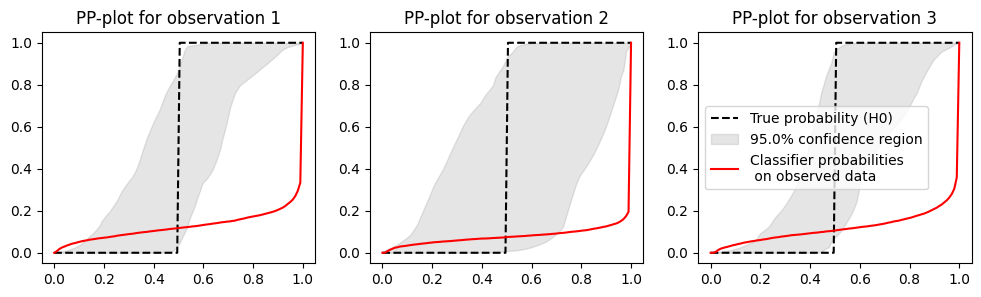

In [8]:
# PP-Plots
from sbi.analysis.plot import pp_plot_lc2st

fig, axes = plt.subplots(1,len(thetas_star), figsize=(12,3))
for i in range(len(thetas_star)):
    probas_data, _ = lc2st.scores_data(
        P_eval=post_samples_star[i],
        x_eval=xs_star[i],
        return_probas=True
    )
    probas_null, _ = lc2st.statistics_null(
        P_eval=post_samples_star[i],
        x_eval=xs_star[i],
        return_probas=True
    )

    pp_plot_lc2st(
        probas=[probas_data],
        probas_null=probas_null,
        labels=["Classifier probabilities \n on observed data"],
        colors=["red"],
        ax=axes[i],
        conf_alpha=conf_alpha,
    )
    axes[i].set_title(f"PP-plot for observation {i+1}")
axes[i].legend()
plt.show()

##### Pairplot with heatmap of classifier probabilities

We can go further and map these predicted probabilities to a pairplot of the samples they were evaluated on, shows us the regions of over and underconfidence of the estimator. This allows us to investigate the nature of the inconsistencies, such as positive/negative bias or under/over dispersion.

> Note: High (resp. low) predicted probability indicates that the classifier is confident about the fact that the sample belongs to the estimated posterior (resp. to the true posterior). This means that the estimator associates too much (resp. not enough) mass to this sample. In other words it is "over-confident" (resp. "under-confident"). 

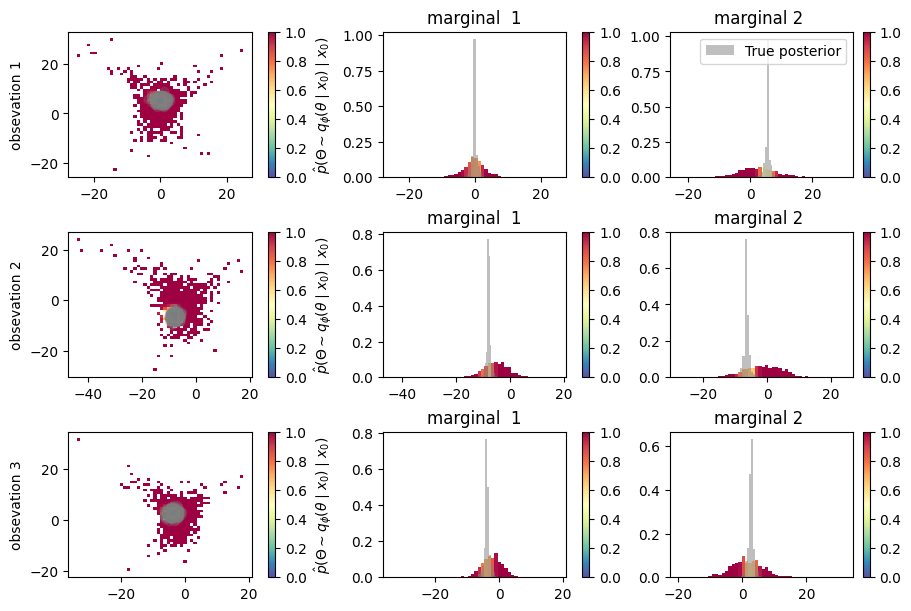

In [9]:
from sbi.analysis.plot import pairplot_with_proba_intensity
from sbi.analysis.test_utils import compute_dfs_with_probas_marginals

fig, axes = plt.subplots(3,len(thetas_star), figsize=(9,6), constrained_layout=True)
for i in range(len(thetas_star)):
    probas_data, _ = lc2st.scores_data(
        P_eval=post_samples_star[i][:1000],
        x_eval=xs_star[i],
        return_probas=True
    )
    dfs = compute_dfs_with_probas_marginals(probas_data[0], post_samples_star[i][:1000])
    # 2d histogram
    pairplot_with_proba_intensity(
        dfs['0_1'],
        dim=2,
        ax=axes[i][0],
        z_space=False,
        n_bins=50
    )
    axes[i][0].scatter(
        ref_samples_star[i][:,0],
        ref_samples_star[i][:,1],
        alpha=0.2, color="gray",
        label="True posterior"
    )

    # marginal 1
    pairplot_with_proba_intensity(
        dfs['0'],
        dim=1,
        ax=axes[i][1],
        z_space=False,
        n_bins=50
    )
    axes[i][1].hist(
        ref_samples_star[i][:,0],
        density=True,
        bins=10,
        alpha=0.5,
        label="True Posterior",
        color="gray"
    )

    # marginal 2
    pairplot_with_proba_intensity(
        dfs['1'],
        dim=1,
        ax=axes[i][2],
        z_space=False,
        n_bins=50
    )
    axes[i][2].hist(
        ref_samples_star[i][:,1],
        density=True,
        bins=10,
        alpha=0.5,
        label="True posterior",
        color="gray"
    )

    axes[i][1].set_title("marginal  1")
    axes[i][2].set_title("marginal 2 ")

    for j in range(3):
        axes[j][0].set_ylabel(f"obsevation {j + 1}")
    axes[0][2].legend()
plt.show()

## The case of Normalizing Flows ($\ell$-C2ST-NF)

$\ell$-C2ST can also be specialized for normalizing flows,leading to improved test performance. The idea is to train and evaluate the classifiers in the space of the base distribution of the normalizing flow, instead of the parameter space that can be highly structures. This comes with two main advantages leading to a statistically more powerful and flexible test: 
- **better trained classifiers:** it is easier to discriminate samples w.r.t. a simple Gaussian than a complex (e.g. multimodal) posterior. 
- **an analytically known null distribution:** it consists of the base distribution of the flow, which is independant from x and the posterior estimator (the original $\ell$-C2ST relies on a permutation method to approximate the null distribution). This also allows to pre-compute the null distribution and re-use it for any new posterior estimator you whish to evaluate.

The new method is implemented within the `LC2ST_NF` class, built on the `LC2ST` class with following major changes:
- no evaluation samples `P_eval` have to be passed to the evaluation methods (e.g. `scores_data`, `statistic_data`, `p_value`, etc.)
- the precomputed `trained_clfs_null` can be passed at initialization
- no permutation method is used inside `train_null`


> Note: **Quick reminder on Normalizing Flows.** We consider a **conditional Normalizing Flow** $q_{\phi}(\theta \mid x)$ with base distribution $p(z) = \mathcal{N}(0,\mathbf{1}_m)$ and bijective transormation $T_{\phi}(.; x)$ defined on $\mathbb{R}^2$ and for all $x \in \mathbb{R}^2$. Sampling from the normalizing flow consists in applying the forward transformation:
>$$\theta = T_{\phi}(z; x) \sim q_{\phi}(\theta \mid x), \quad z\sim p(z)~.$$
>**Characterization of the null hypothesis.** Comparing the estimated and true posterior distributions is equivalent to comapring the base distribtuion to the inverse transformed prior samples: 
>$$ p(\theta \mid x) = q_{\phi}(\theta \mid x) \iff p(T_{\phi}^{-1}(\theta; x)\mid x) = p(T_{\phi}^{-1}(T_{\phi}(z; x); x)) = p(z) = \mathcal{N}(0,\mathbf{1}_m)$$

### Set up $\ell$-C2ST-NF

In [10]:
from sbi.diagnostics.lc2st import LC2ST_NF

flow_inverse_transform = lambda theta, x: npe.net._transform(theta, context=x)[0]
flow_base_dist = torch.distributions.MultivariateNormal(
    torch.zeros(2), torch.eye(2)
) # same as npe.net._distribution

lc2st_nf = LC2ST_NF(
    thetas=theta_cal,
    xs=x_cal,
    posterior_samples=post_samples_cal,
    flow_inverse_transform=flow_inverse_transform,
    flow_base_dist=flow_base_dist,
)
_ = lc2st_nf.train_null()
_ = lc2st_nf.train_data()

Training the classifiers under (H0) - permutation = False:   0%|          | 0/100 [00:00<?, ?it/s]

Training the classifiers under (H0) - permutation = False: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


In [11]:
# Define significance level
conf_alpha = 0.05

#### Quantitative diagnostics
Test statistics, confidence regions and p-values

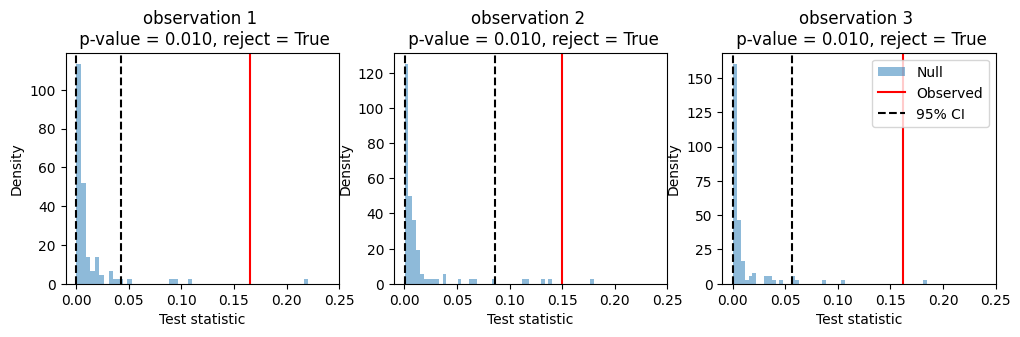

In [12]:
fig, axes = plt.subplots(1,len(thetas_star), figsize=(12,3))
for i in range(len(thetas_star)):
    probas, scores = lc2st_nf.scores_data(
        x_eval=xs_star[i],
        return_probas=True
    )
    T_data = lc2st_nf.statistic_data(x_eval=xs_star[i])
    T_null = lc2st_nf.statistics_null(x_eval=xs_star[i])
    p_value = lc2st_nf.p_value(xs_star[i])
    reject = lc2st_nf.reject(xs_star[i], alpha=conf_alpha)

    # plot 95% confidence interval
    quantiles = np.quantile(T_null, [0, 1-conf_alpha])
    axes[i].hist(T_null, bins=50, density=True, alpha=0.5, label="Null")
    axes[i].axvline(T_data, color="red", label="Observed")
    axes[i].axvline(quantiles[0], color="black", linestyle="--", label="95% CI")
    axes[i].axvline(quantiles[1], color="black", linestyle="--")
    axes[i].set_xlabel("Test statistic")
    axes[i].set_ylabel("Density")
    axes[i].set_xlim(-0.01,0.25)
    axes[i].set_title(
        f"observation {i+1} \n p-value = {p_value:.3f}, reject = {reject}"
    )
axes[i].legend()
plt.show()

#### Qualitative diagnostics

##### PP-Plots

Note that the confidence regions (in grey) are more narrow and "clean" than for the original $\ell$-C2ST.

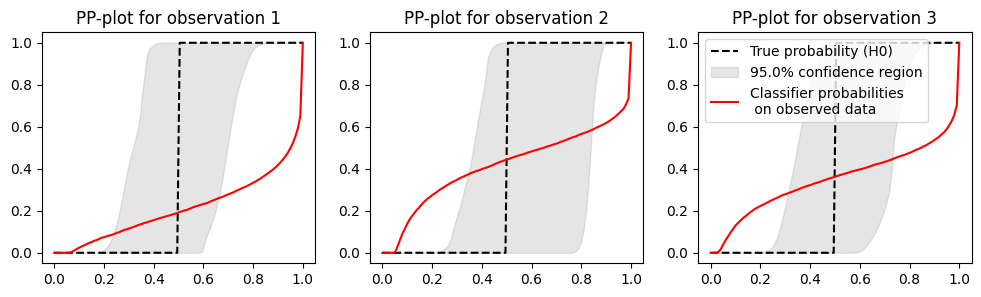

In [13]:
# PP-Plots
from sbi.analysis.plot import pp_plot_lc2st

fig, axes = plt.subplots(1,len(thetas_star), figsize=(12,3))
for i in range(len(thetas_star)):
    probas_data, _ = lc2st_nf.scores_data(
        x_eval=xs_star[i],
        return_probas=True
    )
    probas_null, _ = lc2st_nf.statistics_null(
        x_eval=xs_star[i],
        return_probas=True
    )

    pp_plot_lc2st(
        probas=[probas_data],
        probas_null=probas_null,
        labels=["Classifier probabilities \n on observed data"],
        colors=["red"],
        ax=axes[i],
        conf_alpha=conf_alpha,
    )
    axes[i].set_title(f"PP-plot for observation {i+1}")
axes[i].legend()
plt.show()

##### Heatmap of classifier probabilities

To plot the heatmap pairplots, the argument `z_space=True` can be passed to show the results in the base distribution space, instead of the parameter space, which can be easier to interpret if the posterior space is highly structured.

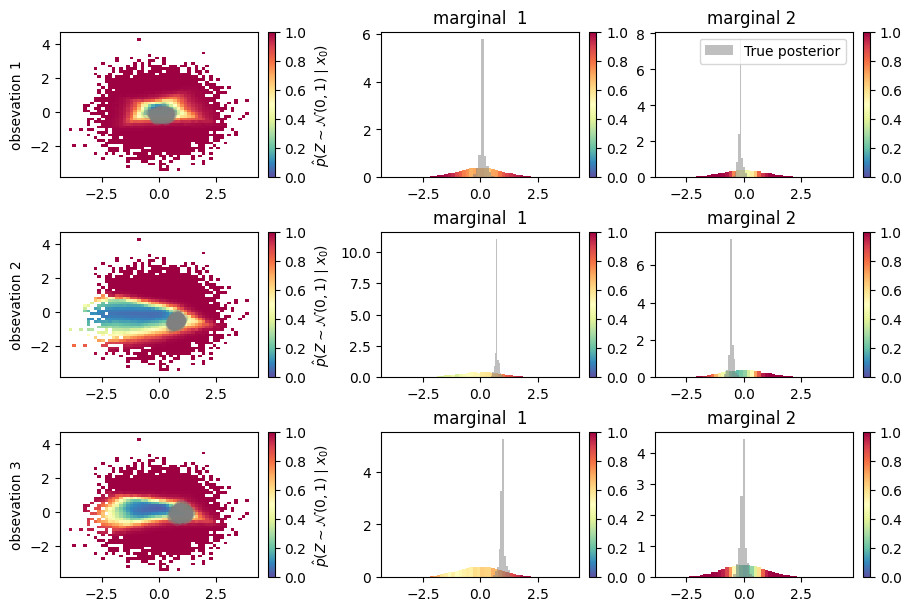

In [14]:
from sbi.analysis.plot import pairplot_with_proba_intensity
from sbi.analysis.test_utils import compute_dfs_with_probas_marginals

fig, axes = plt.subplots(3,len(thetas_star), figsize=(9,6), constrained_layout=True)
for i in range(len(thetas_star)):
    inv_ref_samples = lc2st_nf.flow_inverse_transform(
        ref_samples_star[i], xs_star[i]
    ).detach()
    probas_data, _ = lc2st_nf.scores_data(
        x_eval=xs_star[i],
        return_probas=True
    )
    dfs = compute_dfs_with_probas_marginals(probas_data[0], lc2st_nf.P_eval)
    # 2d histogram
    pairplot_with_proba_intensity(
        dfs['0_1'],
        dim=2,
        ax=axes[i][0],
        z_space=True, # for NFs
        n_bins=50
    )
    axes[i][0].scatter(
        inv_ref_samples[:,0],
        inv_ref_samples[:,1],
        alpha=0.2, color="gray",
        label="True posterior"
    )

    # marginal 1
    pairplot_with_proba_intensity(
        dfs['0'],
        dim=1,
        ax=axes[i][1],
        z_space=True, # for NFs
        n_bins=50
    )
    axes[i][1].hist(
        inv_ref_samples[:,0],
        density=True,
        bins=10,
        alpha=0.5,
        label="True Posterior",
        color="gray"
    )

    # marginal 2
    pairplot_with_proba_intensity(
        dfs['1'],
        dim=1,
        ax=axes[i][2],
        z_space=True, # for NFs
        n_bins=50
    )
    axes[i][2].hist(
        inv_ref_samples[:,1],
        density=True,
        bins=10,
        alpha=0.5,
        label="True posterior",
        color="gray"
    )

    axes[i][1].set_title("marginal  1")
    axes[i][2].set_title("marginal 2 ")

    for j in range(3):
        axes[j][0].set_ylabel(f"obsevation {j + 1}")
    axes[0][2].legend()
plt.show()